This notebook is to run some exploratory work on the cloudquery database in a code-based (crucially, unit testable) way.

In [2]:
import boto3
import psycopg2 as ps
import json
import sqlalchemy as sa
import pandas as pd

REGION="eu-west-1"

#gets the credentials from .aws/credentials
session = boto3.Session(profile_name='deployTools')

#get secret
secret_client = session.client('secretsmanager', REGION)
paginator = secret_client.get_paginator('list_secrets')

response_iterator = paginator.paginate(
    Filters=[
        {
            'Key': 'tag-value',
            'Values': [
                'cloud-query' #App
            ]
        }
    ]
)
secret_arn = list(response_iterator)[0]["SecretList"][0]['ARN']
secret = secret_client.get_secret_value(
    SecretId=secret_arn
)["SecretString"]

secret_json = json.loads(secret)

In [3]:
import sqlalchemy as sa

import psycopg2 as ps
import pandas as pd
import boto3

conn = ps.connect(
    host=secret_json['host'],
    port=secret_json['port'],
    dbname='',
    user=secret_json['username'],
    password=secret_json['password'])

engine = sa.create_engine('postgresql://', creator=lambda: conn)

def select(table_name:str, columns: list[str], db_engine = engine) -> pd.DataFrame:
    return pd.read_sql_table(table_name, con=db_engine, columns=columns)

In [4]:

topics_df = select("guardian_production_status", ['status', 'priority'])
topics_list = topics_df['status'].tolist()
print(topics_df['status'].tolist())

['production', 'testing', 'documentation', 'prototype', 'hackday', 'learning']


In [5]:

non_pe_teams_list = select('guardian_non_p_and_e_github_teams', ['team_name'])['team_name'].tolist()
topics_df = select("github_repositories", ['full_name', 'topics'])
teams_df = select('github_teams', ['name', 'slug'])
#select function doesn't work on views, so we have to use read_sql_query
ownership_df = pd.read_sql_query("select repo_name, github_team_name, github_team_id from view_repo_ownership", con=conn)
new_df = ownership_df.merge(teams_df, how='left', left_on='github_team_name', right_on='name')[['repo_name', 'github_team_name', 'slug']]


/var/folders/2f/pz51c1qs4fj3srjpfrj301d00000gp/T/ipykernel_4855/2319245488.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ownership_df = pd.read_sql_query("select repo_name, github_team_name, github_team_id from view_repo_ownership", con=conn)


array([<Axes: ylabel='count'>], dtype=object)

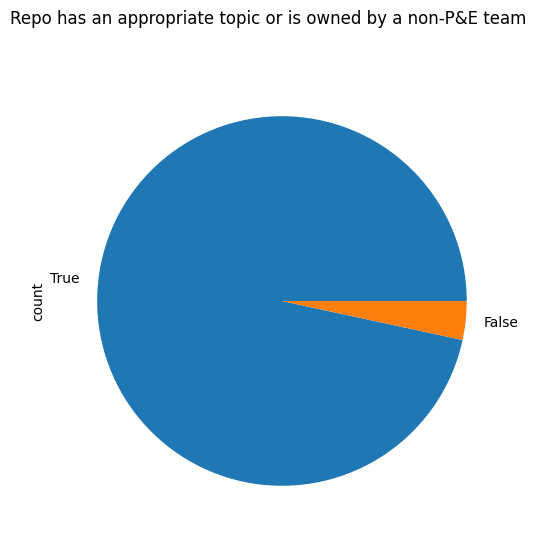

In [6]:
from rules import github_06
topic_rule_df = github_06(new_df, topics_df, topics_list, non_pe_teams_list)
freq = topic_rule_df['github_06'].value_counts()
freq.plot.pie(subplots=True, figsize=(11, 6), title='Repo has an appropriate topic or is owned by a non-P&E team')

In [7]:
import ipywidgets as widgets

selected_topics = widgets.SelectMultiple(
    options=topics_list,
    description='Topics',
)

selected_topics

ModuleNotFoundError: No module named 'ipywidgets'

In [ ]:
freq = ownership_df['github_team_name'].value_counts()
freq

In [ ]:
import matplotlib.pyplot as plt
freq[:15].plot(kind='bar', title='Frequency Count of team name', xlabel='team name', ylabel='Count')
plt.show()

In [ ]:
list(selected_topics.value)

In [ ]:

topics_df = select("guardian_production_status", ['status', 'priority'])
topics_list = topics_df['status'].tolist()
print(topics_df['status'].tolist())

In [ ]:

non_pe_teams_list = select('guardian_non_p_and_e_github_teams', ['team_name'])['team_name'].tolist()
topics_df = select("github_repositories", ['full_name', 'topics'])
teams_df = select('github_teams', ['name', 'slug'])
#select function doesn't work on views, so we have to use read_sql_query
ownership_df = pd.read_sql_query("select repo_name, github_team_name, github_team_id from view_repo_ownership", con=conn)
new_df = ownership_df.merge(teams_df, how='left', left_on='github_team_name', right_on='name')[['repo_name', 'github_team_name', 'slug']]


In [ ]:
from rules import github_06
topic_rule_df = github_06(new_df, topics_df, topics_list, non_pe_teams_list)
freq = topic_rule_df['github_06'].value_counts()
freq.plot.pie(subplots=True, figsize=(11, 6), title='Repo has an appropriate topic or is owned by a non-P&E team')

In [ ]:
import ipywidgets as widgets

selected_topics = widgets.SelectMultiple(
    options=topics_list,
    description='Topics',
)

selected_topics

In [ ]:
freq = ownership_df['github_team_name'].value_counts()
freq

In [ ]:
import matplotlib.pyplot as plt
freq[:15].plot(kind='bar', title='Frequency Count of team name', xlabel='team name', ylabel='Count')
plt.show()

In [ ]:
list(selected_topics.value)